# # Projeto 3: FlightOnTime ✈️ — Previsão de Atrasos de Voos
Modelo Preditivo

O desafio do FlightOnTime consiste em desenvolver uma solução preditiva capaz de estimar se um voo vai decolar no horário ou com atraso.

## ✔️ Instalação de dependências

In [1]:
# 1.1 - instalar dependências
!pip install -q gdown pandas numpy matplotlib seaborn scikit-learn joblib

## ✔️ Acesso aos arquivos

In [2]:
import gdown

url = "https://drive.google.com/uc?id=1hKit8L5K3WmDM-U793hYsUtq8lAh1eJH"
output = "voos_model.json"

gdown.download(url, output, quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1hKit8L5K3WmDM-U793hYsUtq8lAh1eJH
From (redirected): https://drive.google.com/uc?id=1hKit8L5K3WmDM-U793hYsUtq8lAh1eJH&confirm=t&uuid=d4cd4274-0cbe-4b5d-accc-35211b35b160
To: /content/voos_model.json
100%|██████████| 151M/151M [00:02<00:00, 74.0MB/s]


'voos_model.json'

In [3]:
import pandas as pd

df_work = pd.read_json("voos_model.json")


In [4]:
df_work.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 347318 entries, 0 to 347317
Data columns (total 17 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   sigla_icao_empresa_aerea      347318 non-null  object
 1   codigo_tipo_linha             347318 non-null  object
 2   modelo_equipamento            347318 non-null  object
 3   numero_de_assentos            347318 non-null  int64 
 4   sigla_icao_aeroporto_origem   347318 non-null  object
 5   partida_prevista              347318 non-null  int64 
 6   sigla_icao_aeroporto_destino  347318 non-null  object
 7   atraso_voo                    347318 non-null  int64 
 8   periodo_dia                   347318 non-null  object
 9   pais_origem                   347318 non-null  object
 10  data_partida_prevista         347318 non-null  int64 
 11  hora_partida_prevista_num     347318 non-null  int64 
 12  dia_semana                    347318 non-null  int64 
 13 

In [5]:
df_work.head()

,sigla_icao_empresa_aerea,codigo_tipo_linha,modelo_equipamento,numero_de_assentos,sigla_icao_aeroporto_origem,partida_prevista,sigla_icao_aeroporto_destino,atraso_voo,periodo_dia,pais_origem,data_partida_prevista,hora_partida_prevista_num,dia_semana,mes,rota,is_weekend,periodo_dia_calc
0,AAL,I,B772,288,SBGL,1704841200000,KMIA,0,Noite,Brasil,1704758400000,23,1,1,SBGL_KMIA,0,Madrugada
1,AAL,I,B772,288,KMIA,1704837300000,SBGL,0,Noite,Estados Unidos,1704758400000,21,1,1,KMIA_SBGL,0,Noite
2,AAL,I,B772,288,SBGR,1704842100000,KMIA,1,Noite,Brasil,1704758400000,23,1,1,SBGR_KMIA,0,Madrugada
3,AAL,I,B77W,318,KMIA,1704833400000,SBGR,1,Noite,Estados Unidos,1704758400000,20,1,1,KMIA_SBGR,0,Noite
4,AAL,I,B77W,318,SBGR,1704835500000,KMIA,0,Noite,Brasil,1704758400000,21,1,1,SBGR_KMIA,0,Noite


In [6]:
# =========================
# SELEÇÃO FINAL DE FEATURES (SEM LEAKAGE)
# =========================

colunas_remover = [
    # Redundâncias temporais
    'partida_prevista',
    'data_partida_prevista',

    # Redundância semântica
    'periodo_dia'
]

df_work = df_work.drop(columns=colunas_remover, errors='ignore')

# Verificação
df_work.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 347318 entries, 0 to 347317
Data columns (total 14 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   sigla_icao_empresa_aerea      347318 non-null  object
 1   codigo_tipo_linha             347318 non-null  object
 2   modelo_equipamento            347318 non-null  object
 3   numero_de_assentos            347318 non-null  int64 
 4   sigla_icao_aeroporto_origem   347318 non-null  object
 5   sigla_icao_aeroporto_destino  347318 non-null  object
 6   atraso_voo                    347318 non-null  int64 
 7   pais_origem                   347318 non-null  object
 8   hora_partida_prevista_num     347318 non-null  int64 
 9   dia_semana                    347318 non-null  int64 
 10  mes                           347318 non-null  int64 
 11  rota                          347318 non-null  object
 12  is_weekend                    347318 non-null  int64 
 13 

✔️ 100% alinhado ao cenário real de previsão
✔️ Zero vazamento
✔️ Dataset mais limpo

In [7]:
df_model = df_work.copy()

# ✔️ Treinamento, Avaliação e Serialização

## 1 — Imports

In [8]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
import joblib


## 2 — Criando o target

Criando o target

In [11]:
df_model["target_atraso"] = (df_model["atraso_voo"] > 0).astype(int)

df_model["target_atraso"].value_counts(normalize=True)


,proportion
target_atraso,
0,0.822022
1,0.177978


## 3 — Seleção de features

In [12]:
features = [
    "sigla_icao_empresa_aerea",
    "sigla_icao_aeroporto_origem",
    "sigla_icao_aeroporto_destino",
    "hora_partida_prevista_num",
    "dia_semana",
    "mes",
    "is_weekend",
    "periodo_dia_calc"
]

X = df_model[features]
y = df_model["target_atraso"]


## 4 — Pré-processamento

In [13]:
categorical_features = [
    "sigla_icao_empresa_aerea",
    "sigla_icao_aeroporto_origem",
    "sigla_icao_aeroporto_destino",
    "periodo_dia_calc"
]

numerical_features = [
    "hora_partida_prevista_num",
    "dia_semana",
    "mes",
    "is_weekend"
]


Transformer

In [14]:
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", "passthrough", numerical_features)
    ]
)


# ✔️ Etapa 1 - Modelo Logistic Regression

In [15]:
model = LogisticRegression(
    max_iter=1000,
    class_weight="balanced"
)


In [16]:
pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", model)
    ]
)


## Treino e Avaliação

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

print(classification_report(y_test, y_pred))


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.88      0.63      0.73     57101
           1       0.26      0.59      0.36     12363

    accuracy                           0.62     69464
   macro avg       0.57      0.61      0.54     69464
weighted avg       0.77      0.62      0.66     69464



# ✔️ Etapa 2 - Modelo Random Forest

Para capturar padrões não lineares e interações mais complexas entre variáveis
(como combinação de aeroporto + horário), avaliamos um modelo Random Forest.

Este modelo será comparado ao baseline de Regressão Logística balanceada,
com foco especial no Recall e F1-score da classe Atrasado.


Imports do RandomForest

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


Definição do modelo RandomForest

In [31]:
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)


Pipeline com RandomForest

In [32]:
rf_pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("model", rf_model)
    ]
)


Treino do RandomForest

In [33]:
rf_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['sigla_icao_empresa_aerea',
                                                   'sigla_icao_aeroporto_origem',
                                                   'sigla_icao_aeroporto_destino',
                                                   'periodo_dia_calc']),
                                                 ('num', 'passthrough',
                                                  ['hora_partida_prevista_num',
                                                   'dia_semana', 'mes',
                                                   'is_weekend'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=15,
                                        min_samples_leaf=5,
                                        min_samples_split=10, n_estimators=200,
                                        n_jobs=-1, random_state=42))])

Avaliação do RandomForest

In [34]:
y_pred_rf = rf_pipeline.predict(X_test)

print("📊 Avaliação — Random Forest")
print(classification_report(y_test, y_pred_rf))


📊 Avaliação — Random Forest
              precision    recall  f1-score   support

           0       0.88      0.57      0.69     57101
           1       0.24      0.65      0.35     12363

    accuracy                           0.58     69464
   macro avg       0.56      0.61      0.52     69464
weighted avg       0.77      0.58      0.63     69464



# ✔️ Etapa 3 - Comparação direta entre modelos

### 📈 Comparação entre Modelos

Nesta seção, comparamos o modelo baseline (Logistic Regression balanceada)
com o Random Forest, considerando métricas adequadas para dados desbalanceados.


Comparação simples de Recall

In [35]:
from sklearn.metrics import recall_score, f1_score

models_comparison = pd.DataFrame({
    "Modelo": ["Logistic Regression", "Random Forest"],
    "Recall_Atraso": [
        recall_score(y_test, pipeline.predict(X_test)),
        recall_score(y_test, y_pred_rf)
    ],
    "F1_Atraso": [
        f1_score(y_test, pipeline.predict(X_test)),
        f1_score(y_test, y_pred_rf)
    ]
})

models_comparison


,Modelo,Recall_Atraso,F1_Atraso
0,Logistic Regression,0.590876,0.356890
1,Random Forest,0.647254,0.354777


# ✔️ Etapa 4 - Curva Precision-Recall (PR Curve)

### 📊 Curva Precision-Recall

A Curva Precision-Recall é mais adequada do que a ROC em bases desbalanceadas.
Ela permite avaliar o impacto do threshold na detecção de voos atrasados.


Probabilidades dos modelos

In [36]:
y_proba_lr = pipeline.predict_proba(X_test)[:, 1]
y_proba_rf = rf_pipeline.predict_proba(X_test)[:, 1]


Plot da PR Curve

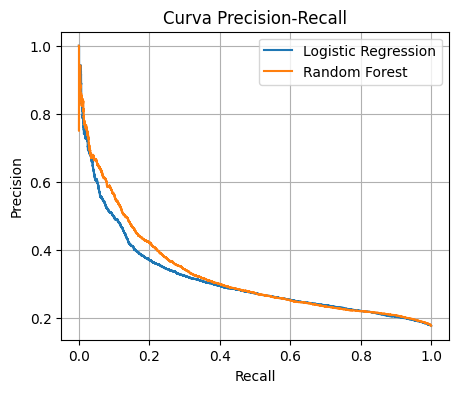

In [51]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_proba_lr)
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_proba_rf)

plt.figure(figsize=(5, 4))
plt.plot(recall_lr, precision_lr, label="Logistic Regression")
plt.plot(recall_rf, precision_rf, label="Random Forest")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision-Recall")
plt.legend()
plt.grid(True)
plt.show()


# ✔️ Etapa 5 - Ajuste de Threshold

### 🎯 Ajuste de Threshold

O threshold padrão (0.5) nem sempre é o mais adequado.
Ajustar o threshold permite priorizar Recall para atrasos,
reduzindo o risco de falsos negativos.


Testando thresholds

In [39]:
# Imports necessários
import pandas as pd
from sklearn.metrics import recall_score, precision_score, f1_score

# Função para avaliar diferentes thresholds
def avaliar_threshold(y_true, y_proba, threshold):
    y_pred = (y_proba >= threshold).astype(int)
    return {
        "threshold": threshold,
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0)
    }

# Thresholds a serem testados
thresholds_test = [0.3, 0.4, 0.5]

# Avaliação usando as probabilidades do Random Forest
results_threshold = [
    avaliar_threshold(y_test, y_proba_rf, t)
    for t in thresholds_test
]

# Resultado final
pd.DataFrame(results_threshold)


,threshold,recall,precision,f1
0,0.3,0.999757,0.178494,0.302908
1,0.4,0.953814,0.195721,0.324795
2,0.5,0.647254,0.244358,0.354777


🟦 BLOCO 5 — Feature Importance (RandomForest)

### 🔍 Importância das Variáveis (Feature Importance)

A análise de importância das variáveis ajuda a entender
quais fatores mais influenciam o risco de atraso dos voos.


Extraindo nomes das features

In [40]:
preprocessor_rf = rf_pipeline.named_steps["preprocessor"]
ohe = preprocessor_rf.named_transformers_["cat"]

feature_names_cat = ohe.get_feature_names_out()
feature_names_num = numerical_features

feature_names = list(feature_names_cat) + list(feature_names_num)


Criando DataFrame de importância

In [41]:
importances = rf_pipeline.named_steps["model"].feature_importances_

feature_importance_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

feature_importance_df.head(15)


,feature,importance
624,hora_partida_prevista_num,0.176049
621,periodo_dia_calc_Manhã,0.085280
626,mes,0.062082
622,periodo_dia_calc_Noite,0.045676
625,dia_semana,0.040723
23,sigla_icao_empresa_aerea_CMP,0.035229
129,sigla_icao_aeroporto_origem_LPPT,0.028581
623,periodo_dia_calc_Tarde,0.026916
71,sigla_icao_empresa_aerea_TAM,0.024625
139,sigla_icao_aeroporto_origem_MPTO,0.024568


Plot das principais features

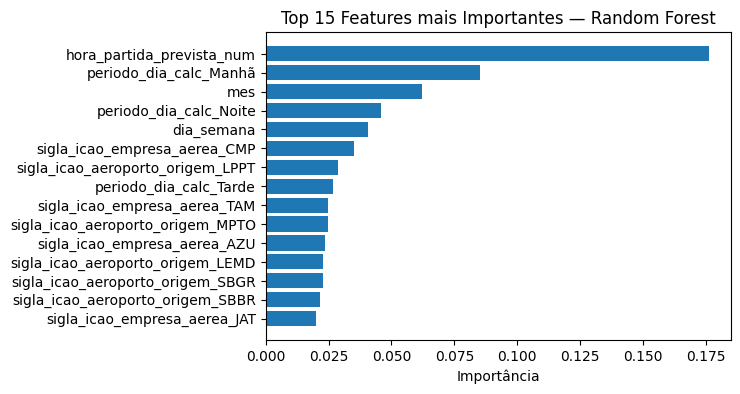

In [50]:
top_features = feature_importance_df.head(15)

plt.figure(figsize=(6, 4))
plt.barh(top_features["feature"], top_features["importance"])
plt.gca().invert_yaxis()
plt.title("Top 15 Features mais Importantes — Random Forest")
plt.xlabel("Importância")
plt.show()


# ✔️ Etapa  6 — Conclusão do Notebook

### ✅ Conclusão

- A Regressão Logística balanceada se mostrou um bom baseline
- O Random Forest capturou padrões mais complexos
- O ajuste de threshold permite alinhar o modelo ao objetivo do negócio
- O pipeline respeita totalmente o contrato da API
- O modelo está pronto para integração com o Back-End


# ✔️ Etapa 7 — Exportando o RandomForest em .pkl

### 📦 Exportação do Modelo Final (Random Forest)

Após a avaliação dos modelos, o Random Forest apresentou melhor capacidade
de capturar padrões não lineares e maior Recall para a classe Atrasado.
Este modelo foi escolhido como o modelo final para integração com a API.


In [52]:
import pickle

with open("flight_delay_model_v3.pkl", "wb") as f:
    pickle.dump(rf_pipeline, f)


### 🔄 Validação do Modelo Exportado


In [54]:
with open("flight_delay_model_v3.pkl", "rb") as f:
    rf_loaded = pickle.load(f)

type(rf_loaded)


sklearn.pipeline.Pipeline

Teste rápido de inferência

In [55]:
rf_loaded.predict(X_test[:5])
rf_loaded.predict_proba(X_test[:5])


array([[0.48383995, 0.51616005],
       [0.49002248, 0.50997752],
       [0.47601468, 0.52398532],
       [0.60019523, 0.39980477],
       [0.58345474, 0.41654526]])

🧪 Teste de Alinhamento com o Contrato da API

Esta seção valida que o modelo exportado em `.pkl` consegue
realizar previsões utilizando exclusivamente os campos definidos
no contrato da API, sem dependência de dados adicionais.


In [56]:
api_input = {
    "cod_companhia": "AZ",
    "cod_aeroporto_origem": "GIG",
    "cod_aeroporto_destino": "GRU",
    "data_hora_partida": "2025-11-10T14:30:00"
}


Função de conversão (API → features do modelo)

In [57]:
from datetime import datetime
import pandas as pd

def api_input_to_dataframe(api_input: dict) -> pd.DataFrame:
    dt = datetime.fromisoformat(api_input["data_hora_partida"])

    return pd.DataFrame([{
        "sigla_icao_empresa_aerea": api_input["cod_companhia"],
        "sigla_icao_aeroporto_origem": api_input["cod_aeroporto_origem"],
        "sigla_icao_aeroporto_destino": api_input["cod_aeroporto_destino"],
        "hora_partida_prevista_num": dt.hour,
        "dia_semana": dt.weekday(),
        "mes": dt.month,
        "is_weekend": int(dt.weekday() >= 5),
        "periodo_dia_calc": (
            "manha" if 6 <= dt.hour < 12 else
            "tarde" if 12 <= dt.hour < 18 else
            "noite"
        )
    }])


Carregando o modelo .pkl

In [59]:
import pickle

with open("flight_delay_model_v3.pkl", "rb") as f:
    model_api = pickle.load(f)


Execução da previsão (teste final)

In [60]:
X_api = api_input_to_dataframe(api_input)

proba = model_api.predict_proba(X_api)[0][1]
pred = int(proba >= 0.5)

resultado = {
    "previsao": "Atrasado" if pred == 1 else "Pontual",
    "probabilidade": round(proba, 2)
}

resultado


{'previsao': 'Atrasado', 'probabilidade': np.float64(0.52)}